# Preprocessing and Modeling

In [1]:
#load standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#NLP libraries
import re
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk.sentiment import SentimentIntensityAnalyzer

#statistical libraries
from scipy.stats import pearsonr
from prophet import Prophet 
from prophet.diagnostics import performance_metrics
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

#silence warnings
import warnings
warnings.filterwarnings(action='once')

Importing plotly failed. Interactive plots will not work.


In [2]:
#read in dataset
df = pd.read_csv('../Data/all_data.csv')
df['Date'] = pd.to_datetime(df.Date)
df.head()

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,datetime,Headlines,Time,Description,Date,source
0,2017-12-22 18:52:00,Cramer: Never buy a stock all at once — you'll...,"6:52 PM ET Fri, 22 Dec 2017",Jim Cramer doubled down on his key investing r...,2017-12-22,CNBC
1,2017-12-22 19:07:00,Cramer: I helped investors through the 2010 fl...,"7:07 PM ET Fri, 22 Dec 2017","Jim Cramer built on his ""nobody ever made a di...",2017-12-22,CNBC
2,2017-12-22 19:07:00,Cramer says owning too many stocks and too lit...,"7:07 PM ET Fri, 22 Dec 2017",Jim Cramer broke down why owning fewer stocks ...,2017-12-22,CNBC
3,2017-12-26 10:15:00,Markets lack Christmas cheer,"10:15 AM ET Tue, 26 Dec 2017","According to Kensho, here's how markets have f...",2017-12-26,CNBC
4,2017-12-27 10:13:00,S&P tends to start new year bullish after this...,"10:13 AM ET Wed, 27 Dec 2017",The S&P is on track to end the year up 20 perc...,2017-12-27,CNBC


## Sentiment Analysis of Article Headlines and Descriptions

In [3]:
#set standard english stop words
stop_words = set(stopwords.words('english'))

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#removal of additional unwanted words that probably do not pertain to stock market trends
addtln_stop_words = ['cramer','jim','mad','money','market','stock','earnings','guardian']
#update stop words
stop_words.update(addtln_stop_words)
#put in regex digestiable form
stop_words_regex = r'\b|\b'.join(stop_words)

In [5]:
#get compound sentiment analysis polarity scores
sia = SentimentIntensityAnalyzer()

def sentiment_scores(df0):
    #remove stopwords from headlines
    df0['HL_score'] = df0['Headlines'].apply(lambda hl: re.sub(pattern=stop_words_regex, repl='', string=hl,flags=re.IGNORECASE))
    #get sentiment score
    df0['HL_score'] = df0['HL_score'].apply(lambda hl : sia.polarity_scores(hl)['compound'])
    #remove stopwords from descriptions
    df0['Desc_score'] = df0['Description'].apply(lambda hl: re.sub(pattern=stop_words_regex, repl='', string=hl,flags=re.IGNORECASE))
    #get sentiment score
    df0['Desc_score'] = df0['Desc_score'].apply(lambda hl : sia.polarity_scores(hl)['compound'])
    #averaged HL and Desc scores
    df0['Avg_score'] = df0.iloc[:,-2:].mean(axis=1)
    #return final dataset
    return(df)

In [6]:
#call function to get sentiment scores
df1 = sentiment_scores(df)
#inspect new dataframe
df1.head()

,datetime,Headlines,Time,Description,Date,source,HL_score,Desc_score,Avg_score
0,2017-12-22 18:52:00,Cramer: Never buy a stock all at once — you'll...,"6:52 PM ET Fri, 22 Dec 2017",Jim Cramer doubled down on his key investing r...,2017-12-22,CNBC,-0.2596,-0.2057,-0.23265
1,2017-12-22 19:07:00,Cramer: I helped investors through the 2010 fl...,"7:07 PM ET Fri, 22 Dec 2017","Jim Cramer built on his ""nobody ever made a di...",2017-12-22,CNBC,-0.4019,-0.4404,-0.42115
2,2017-12-22 19:07:00,Cramer says owning too many stocks and too lit...,"7:07 PM ET Fri, 22 Dec 2017",Jim Cramer broke down why owning fewer stocks ...,2017-12-22,CNBC,-0.4654,0.0000,-0.23270
3,2017-12-26 10:15:00,Markets lack Christmas cheer,"10:15 AM ET Tue, 26 Dec 2017","According to Kensho, here's how markets have f...",2017-12-26,CNBC,0.2500,0.0000,0.12500
4,2017-12-27 10:13:00,S&P tends to start new year bullish after this...,"10:13 AM ET Wed, 27 Dec 2017",The S&P is on track to end the year up 20 perc...,2017-12-27,CNBC,0.0000,0.3400,0.17000


In [7]:
#statistically significant correlation between headline and describtion scores
pearsonr(df1.HL_score,df1.Desc_score)

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.6105779043222519, 0.0)

In [8]:
agg_cols = ['HL_score','Desc_score','Avg_score']
#average scores by day
df_agg = df1.groupby(['Date','source'])[agg_cols].mean().reset_index()
#df_agg = df_agg.reset_index().set_index('Date')
df_pt = pd.pivot_table(df_agg,values=agg_cols,index=['Date'],columns=['source']).dropna()
df_pt.head()

Avg_score                     Desc_score                      \
source          CNBC  Guardian   Reuters       CNBC  Guardian   Reuters   
Date                                                                      
2018-03-20 -0.060690  0.070340 -0.038871   0.072240  0.070340 -0.019145   
2018-03-21  0.153990 -0.100910  0.070549   0.226400 -0.100910  0.127581   
2018-03-22  0.107664  0.001905  0.018960   0.076486  0.001905  0.065547   
2018-03-23  0.311987 -0.073195  0.082053   0.260575 -0.073195  0.174907   
2018-03-26  0.079470  0.027845  0.028825   0.175700  0.027845  0.042000   

            HL_score                      
source          CNBC  Guardian   Reuters  
Date                                      
2018-03-20 -0.193620  0.070340 -0.058598  
2018-03-21  0.081580 -0.100910  0.013518  
2018-03-22  0.138843  0.001905 -0.027626  
2018-03-23  0.363400 -0.073195 -0.010802  
2018-03-26 -0.016760  0.027845  0.015651

In [9]:
#average scores for each grouping
df_pt.mean().round(2).to_frame().rename(columns={0:'Mean Scores'})

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mean Scores
           source               
Avg_score  CNBC             0.10
           Guardian        -0.08
           Reuters          0.02
Desc_score CNBC             0.15
           Guardian        -0.08
           Reuters          0.05
HL_score   CNBC             0.05
           Guardian        -0.08
           Reuters         -0.01

We see that CBNC has the both the most positive mean sentiment scores among the three news sources across all three groupings. Article description sentiment analysis scores (not available for Guardian, which is just the same as the headline scores) have a larger magnitude than the corresponding headlines scores. One reason for this is that the headlines generally contain the names of persons, companies, or industries, which do not register as well on a sentiment scale.

Hence, the article descriptions are more likely to accurately convey the sentiment of the report.

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Average Sentiment Scores'}, xlabel='Date'>

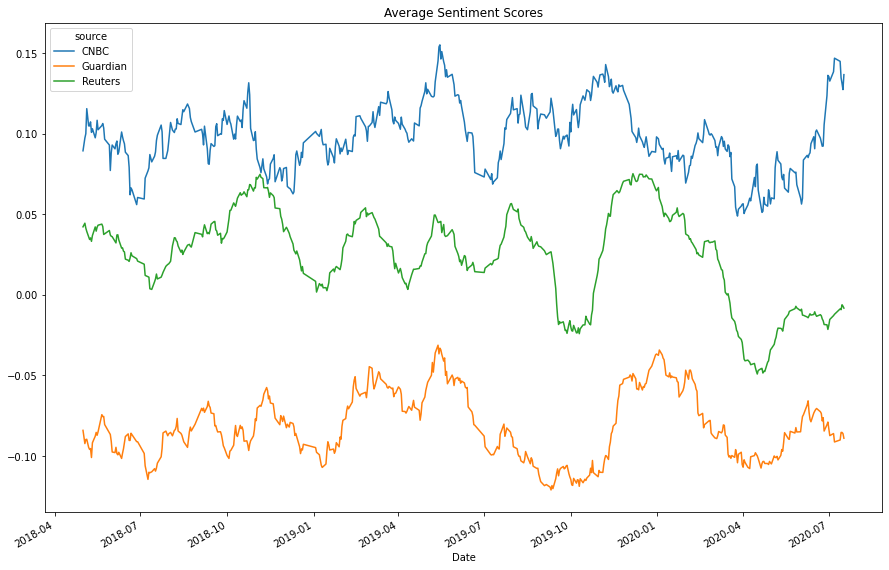

In [10]:
df_pt.loc[:,'Avg_score'].rolling(30).mean().plot(figsize=(15,10),title='Average Sentiment Scores')

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Article Description Sentiment Scores'}, xlabel='Date'>

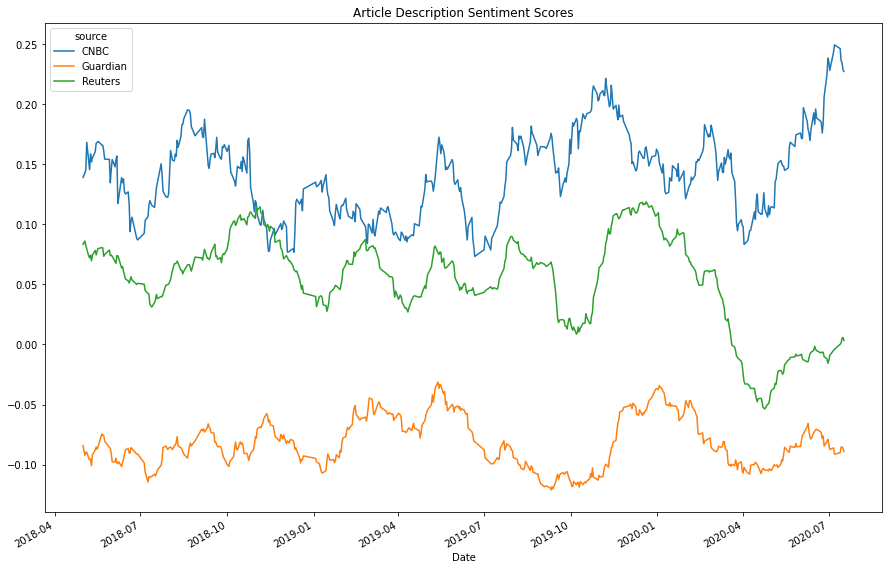

In [11]:
df_pt.loc[:,'Desc_score'].rolling(30).mean().plot(figsize=(15,10),title='Article Description Sentiment Scores')

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Article Headline Sentiment Scores'}, xlabel='Date'>

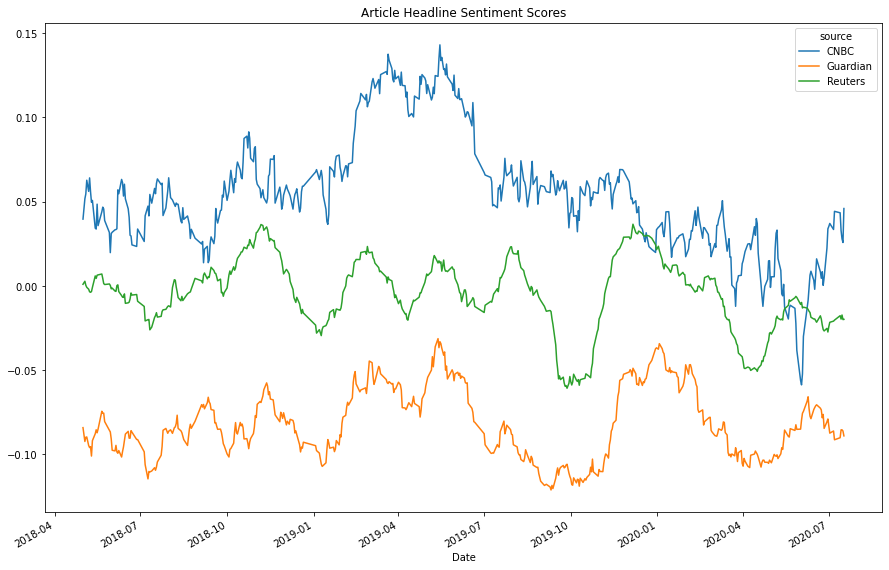

In [12]:
df_pt.loc[:,'HL_score'].rolling(30).mean().plot(figsize=(15,10),title='Article Headline Sentiment Scores')

The rolling averaged headline, article description, and average scores of the two generally follow a similar trend over time for all three news sources. However, we notice that the general sentiment scores are on average much more positive for CNBC, followed by Reuters, which is more neutral, and then by the generally negative sentiment scores for The Guardian. 

Therefore, we can normalize the scores by subtracting the average.

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Normalized Average Sentiment Scores'}, xlabel='Date'>

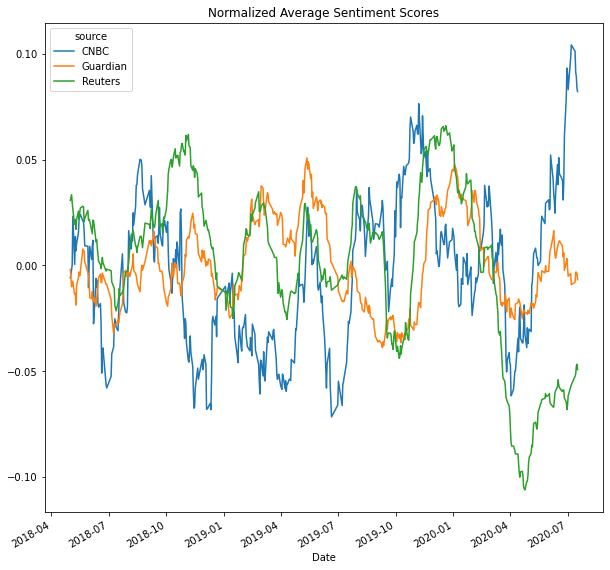

In [13]:
df_pt_norm = df_pt-df_pt.mean()
df_pt_norm.loc[:,'Desc_score'].rolling(30).mean().plot(figsize=(10,10),title='Normalized Average Sentiment Scores')

In [14]:
#correlation between article description scores
def news_source_corr(colY):
    d1 = df_pt_norm.loc[:,colY]['CNBC']
    d2 = df_pt_norm.loc[:,colY]['Guardian']
    d3 = df_pt_norm.loc[:,colY]['Reuters']

    print(pearsonr(d1,d2))
    print(pearsonr(d1,d3))
    print(pearsonr(d2,d3))

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
news_source_corr('Avg_score')

(-0.0612174602859409, 0.1637487653082489)
(0.10433212456696274, 0.017425211394211434)
(0.043233514233845693, 0.3256014059842726)


In [16]:
news_source_corr('HL_score')

(-0.07643850040156942, 0.08190531179578421)
(0.07430691410061158, 0.09082055098067443)
(0.09929506235306007, 0.023682797770818494)


In [17]:
news_source_corr('Desc_score')

(-0.018709312550572853, 0.670663867261494)
(0.06833754887518208, 0.11996962210711981)
(-0.0010096442318841565, 0.9816934841252112)


Interestingly, the headlines of each news source correlate well to one another. However, this might be a spurious conclusion due to the lower magnitudes of the headline scores.

### Adding in Stock Market Data

In [18]:
#Stock market data
sp500 = pd.read_csv('../Data/S&P_500_HistoricalPrices_2017-12-22__2020-07-19.csv')
#set index to date
sp500 = sp500.set_index(pd.to_datetime(sp500.Date))
#get difference in closing price from previous business day
sp500['diff'] = sp500[' Close'].pct_change()
sp500=sp500.sort_index()
sp500.head()

,Date,Open,High,Low,Close,diff
Date,,,,,,
2017-12-22,12/22/2017,2684.22,2685.35,2678.13,2683.34,0.001060
2017-12-26,12/26/2017,2679.09,2682.74,2677.96,2680.50,-0.000790
2017-12-27,12/27/2017,2682.10,2685.64,2678.91,2682.62,-0.001831
2017-12-28,12/28/2017,2686.10,2687.66,2682.69,2687.54,0.005210
2017-12-29,12/29/2017,2689.15,2692.12,2673.61,2673.61,-0.008235


C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


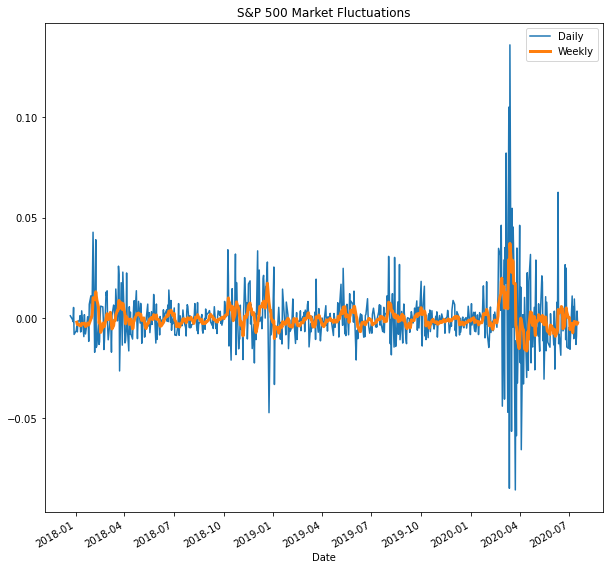

In [19]:
sp500['diff'].plot(figsize=(10,10),title='S&P 500 Market Fluctuations',label='Daily')
sp500['diff'].rolling(7).mean().plot(figsize=(10,10),label='Weekly',linewidth=3)
plt.legend()

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


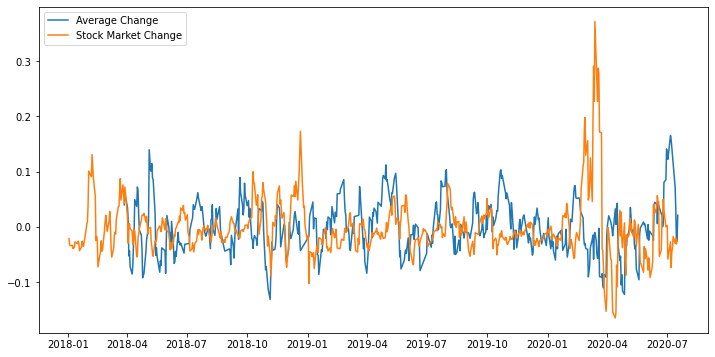

In [20]:
plt.figure(figsize=(12,6))
#rolling average
window_size = 7
plt.plot(df_pt_norm.loc[:,'Avg_score']['CNBC'].rolling(window_size).mean())
plt.plot(10*sp500['diff'].rolling(window_size).mean())
plt.legend(['Average Change','Stock Market Change'])

Now that we have our stock market data, it is time to join it to the sentiment analysis scores for the same dates. One issue is that articles are published every day of the week (including holidays), whereas the markets are only open during the week. We can take the averaged scores and market fluctuations per week to normalize these metrics.

In [21]:
#Merge Dataframes together based on weekly average scores
df_agg2 = df_pt_norm.resample('W-Mon').mean().dropna()
sp500_agg = sp500.resample('W-Mon').mean().dropna()[['diff']]

df_merged = pd.merge(df_agg2,sp500_agg,how='inner',left_index=True,right_index=True)
#rename columns
cols=['CNBC_Avg','Guardian_Avg','Reuters_Avg','CNBC_desc','Guardian_desc','Reuters_desc',\
     'CNBC_HL','Guardian_HL','Reuters_HL','diff']
df_merged.columns = cols
#
df_merged.head()

C:\Users\bwitt\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,CNBC_Avg,Guardian_Avg,Reuters_Avg,CNBC_desc,Guardian_desc,Reuters_desc,CNBC_HL,Guardian_HL,Reuters_HL,diff
Date,,,,,,,,,,
2018-03-26,0.018920,0.067277,0.008549,0.017199,0.067277,0.025456,0.020640,0.067277,-0.008359,0.008043
2018-04-02,0.011110,-0.020415,-0.002051,-0.115924,-0.020415,0.010752,0.138145,-0.020415,-0.014855,-0.000067
2018-04-09,-0.091579,-0.104847,0.023890,-0.050638,-0.104847,0.044822,-0.132519,-0.104847,0.002958,-0.003123
2018-04-16,0.073572,0.040146,0.013976,0.084450,0.040146,0.013015,0.062694,0.040146,0.014938,-0.003665
2018-04-23,-0.046518,0.007286,-0.017783,0.057719,0.007286,-0.007347,-0.150756,0.007286,-0.028220,0.005409


In [22]:
#pearson scores between market fluctuations and sentiment analysis scores
print(pearsonr(df_merged.CNBC_desc,df_merged['diff']))
print(pearsonr(df_merged.Guardian_desc,df_merged['diff']))
print(pearsonr(df_merged.Reuters_desc,df_merged['diff']))

(-0.11434038075434194, 0.2117423242680778)
(-0.056339680806741066, 0.5393531617865182)
(-0.06347216710150577, 0.4891606452921027)


C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


It appears from a simple pearson r test that there is not a statistically significant corrleation between the sentiment analysis compound score of the CNBC articles and the S&P500 fluctuations. However, the p-value is still smaller than for the other two news sources. One reason is that both The Guardian and Reuters are British outlets whereas CNBC covers American markets. Hence, the correlation with the U.S. S&P500 is unsurprisingly better with a U.S. news publisher.

Henceforth, we focus only on the CNBC scores in this analysis.In addtion, we will restrict the analysis to only the article description sentiment scores as they tend to better represent the true sentiment of the report.

Although the correlation between the CNBC sentiment scores and the market fluctuations is not statisitically significant (alpha=0.05), perhaps there an optimal lag between the news publication date and the averaged weekly market fluctuations? Let's find out.

In [23]:
#Code adapted from https://towardsdatascience.com/time-series-forecasting-a-getting-started-guide-c435f9fa2216
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [24]:
def best_lag(d1,d2,max_lag=6):
    rs = [(lag,crosscorr(d1,d2, lag)) for lag in range(-max_lag,max_lag+1)]
    rs = pd.DataFrame(rs,columns=['Offset','Corr'])
    offset = np.argmax(rs.Corr)-max_lag
    f,ax=plt.subplots(figsize=(14,3))
    ax.plot(rs.Offset,rs.Corr)
    ax.axvline(0,color='k',linestyle='--',label='Center')
    ax.axvline(offset,color='r',linestyle='--',label='Peak correlation')
    ax.set(title=f'Headline Scores\nOffset = {offset} weeks (corr={np.round(np.max(rs.Corr),2)})')
    plt.legend()

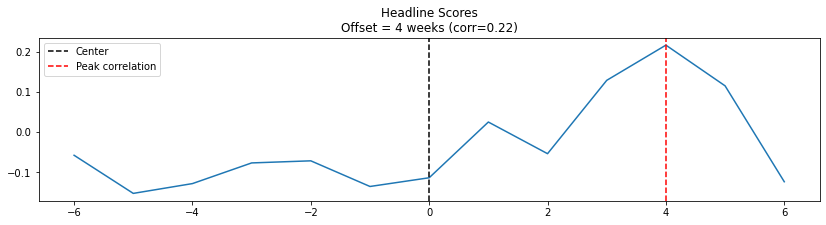

In [25]:
d1 = df_merged['diff']
d2 = df_merged['CNBC_desc']

best_lag(d1,d2)

Checking the correlation between the article description sentiment scores with the changes in the S&P 500 stock market data shows a postive correlation with future market fluctuations, but more negatively correlated with past fluctuations. '

The best correlation comes from the sentiment scores of article description scores at 4 weeks ahead. That is, the sentiment of what was printed 4 weeks ago is correlated with the direction of the fluctuations of the S&P 500 presently. 

In [26]:
#pearson r for CNBC article sentiment scores and S&P 500 fluctuations shifted back 4 weeks
df_merged['shift_diff'] = df_merged['diff'].shift(-4)
np.round(pearsonr(df_merged.dropna()['CNBC_desc'],df_merged.dropna()['shift_diff']),2)

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.22, 0.02])

The correlation between the shifted S&P 500 fluctuations and CNBC article sentiment analysis scores is now statistically significant (p=0.01). 

### Optimal Window Size

Although we already see a good and statistically significant correlation between the sentiment scores of CNBC article descriptions with price changes in the S&P 500, it may be possible to get an even stronger correlation by smoothing the data with a moving average.

In [27]:
def find_window_size(window_size,col='CNBC_desc',df=df_merged,max_lag=10):
    df = df.rolling(window_size).mean()
    d1 = df['shift_diff']
    d2 = df[col]
    rs = [(lag,crosscorr(d1,d2, lag)) for lag in range(-max_lag,max_lag+1)]
    rs = pd.DataFrame(rs,columns=['Offset','Corr'])
    offset = np.argmax(rs.Corr)-max_lag
    max_corr = np.max(np.abs(rs.Corr))
    return(offset,max_corr)

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
#find optimal window size for maximizing correlation 
def max_corr(col,max_size=15):
    ws = pd.DataFrame([(i,find_window_size(i,col)) for i in range(1,max_size)],columns=['Moving Average Window Size','Correlation'])
    ws2 = ws.Correlation.apply(pd.Series)
    ws2.columns=['Offset','Corr']
    ws2.index = ws2.index + 1
    ws2.index.rename('Moving Average Window Size',inplace=True)
    return(ws2)

<AxesSubplot:title={'center':'Correlation as function of Moving Average Window Size'}, xlabel='Moving Average Window Size'>

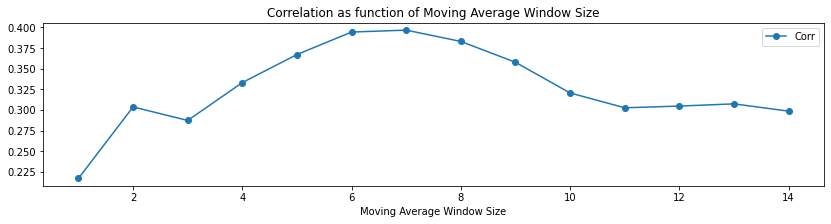

In [29]:
max_corr('CNBC_desc').plot(y='Corr',marker='o',figsize=(14,3),title='Correlation as function of Moving Average Window Size')

Indeed, we see that the correlation improves to 0.41 when a moving average of 6 weeks is used. Let's create a new dataframe where we aggregate the data using a moving average of 6 weeks.

In [30]:
#new MA dataframe
optimal_ma_widow = 6 #weeks
df_ma = df_merged.rolling(optimal_ma_widow).mean().dropna()
df_ma.head(2)

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,CNBC_Avg,Guardian_Avg,Reuters_Avg,CNBC_desc,Guardian_desc,Reuters_desc,CNBC_HL,Guardian_HL,Reuters_HL,diff,shift_diff
Date,,,,,,,,,,,
2018-04-30,-0.012970,-0.004391,0.015923,-0.009238,-0.004391,0.029003,-0.016703,-0.004391,0.002843,0.000848,0.000331
2018-05-07,0.006307,-0.016890,0.011937,0.003556,-0.016890,0.021754,0.009057,-0.016890,0.002120,-0.000703,-0.001287


### Window Time lagged correlation analysis

Although we have determined the averaged correlations between the S&P 500 fluctuations and the sentiment analysis scores for the CNBC article descriptions, it would be interesting to see the strength of the correlation over time. Is the correlation consistently positive or is there more noise? Let's check.

In [31]:
def window_corr(col='CNBC_desc',dfw=df_ma,splits=10,max_lag=6,tick_space=1):
    # Windowed time lagged cross correlation
    t1 = dfw['shift_diff']
    t2 = dfw[col]
    df = dfw
    samples_per_split = int(np.floor(df.shape[0]/splits))
    #calulate correlations per window
    rss=[]
    for t in range(0, splits):
        d1 = t1.iloc[(t)*samples_per_split:(t+1)*samples_per_split]
        d2 = t2.iloc[(t)*samples_per_split:(t+1)*samples_per_split]
        rs = [crosscorr(d1,d2, lag) for lag in range(-max_lag,max_lag+1)]
        rss.append(rs)
    rss = pd.DataFrame(rss)
    f,ax = plt.subplots(figsize=(12,8))
    sns.heatmap(rss,cmap='RdBu_r',ax=ax)
    ax.set(title=f'Windowed Time Lagged Cross Correlation. Window = {samples_per_split} weeks', xlabel='Offset',ylabel='Window epochs')
    ax.set_xticks([tick+0.5 for tick in range(0,2*max_lag+1,tick_space)]),
    ax.set_xticklabels([tick for tick in range(-max_lag,max_lag+1,tick_space)])

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


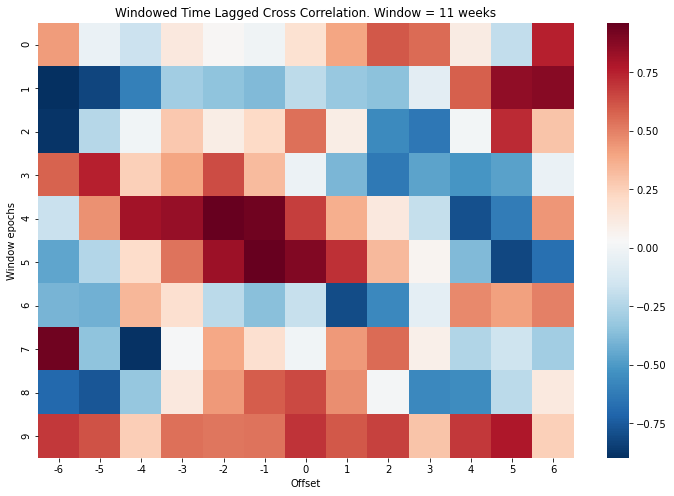

In [32]:
window_corr(splits=10)

The heatmap above shows the correlations between the 4-week shifted S&P 500 fluctuations against the CNBC article description scores aggregated by a moving average of 6 weeks across 10 epochs. Each epoch is 11 weeks long and shows the correlations between -6 and +6 week offsets from the optimal 4-week shift. Note that, by and large, at offset = 0, the correlation is almost always positive or close to neutral, suggesting that our averaged positive correlation is meaningful. If the correlation were to jump between positive and negative, like seen when examining offset values around 0, the noise would make any predictions of the stock market fluctuations unreliable. 

Interestingly, some epochs have consistently positive or negative correlations across all offset values.

## Time Series Model Fitting

Building on the above analysis of the correlations across epochs, what if there was a pattern with how the correlations varied over time. For instance, does CNBC have regular intervals where the sentiment of their articles align more closely with the market and other periods where the correlation is not quite as stong. Perhaps there are times of the month or year where reporting is less focused on what is currently going on in the market and rather takes on a more retrospective or predictive nature.

We can look at the difference between the sentiment analysis scores of the CNBC article descriptions and the S&P 500 fluctuations to see if any trends appear.

In [33]:
df_ma['Delta_ts'] = df_ma['CNBC_desc'] - df_ma['shift_diff']
df_ma.head()

,CNBC_Avg,Guardian_Avg,Reuters_Avg,CNBC_desc,Guardian_desc,Reuters_desc,CNBC_HL,Guardian_HL,Reuters_HL,diff,shift_diff,Delta_ts
Date,,,,,,,,,,,,
2018-04-30,-0.012970,-0.004391,0.015923,-0.009238,-0.004391,0.029003,-0.016703,-0.004391,0.002843,0.000848,0.000331,-0.009569
2018-05-07,0.006307,-0.016890,0.011937,0.003556,-0.016890,0.021754,0.009057,-0.016890,0.002120,-0.000703,-0.001287,0.004843
2018-05-14,-0.002146,-0.005610,0.018380,0.015430,-0.005610,0.025594,-0.019722,-0.005610,0.011165,-0.001178,-0.001492,0.016922
2018-05-21,0.002778,0.010196,0.020090,0.015002,0.010196,0.028296,-0.009447,0.010196,0.011885,-0.000815,-0.000989,0.015991
2018-05-28,-0.010498,-0.003409,0.011031,0.001122,-0.003409,0.020274,-0.022117,-0.003409,0.001789,0.000331,-0.000019,0.001141


C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Time Series of difference between CNBC article sentiment scores and S&P 500 fluctuations'}, xlabel='Date'>

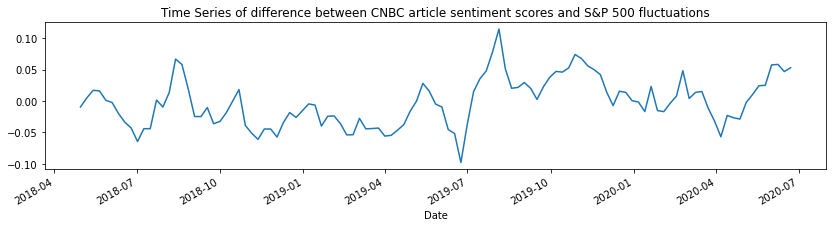

In [34]:
df_ma['Delta_ts'].plot(figsize=(14,3),title='Time Series of difference between CNBC article sentiment scores and S&P 500 fluctuations')

In [55]:
#define simple time series
dsts_freq = df_ma['Delta_ts'].asfreq(freq='W-Mon')#.dropna()
dsts = df_ma['Delta_ts']
print(dsts.head())

#split data into test and training sets
frac_train = 0.75
n_train = int(dsts.shape[0]*frac_train)
#training dataset
dsts_train = dsts_freq.iloc[0:n_train]
ts_train = dsts.iloc[0:n_train]
#testing dataset
dsts_test = dsts_freq.iloc[n_train:]

#Augmented Dicky-Fuller test for unit root in time series
#print p-value
np.round(adfuller(dsts)[1],3)

Date
2018-04-30   -0.009569
2018-05-07    0.004843
2018-05-14    0.016922
2018-05-21    0.015991
2018-05-28    0.001141
Name: Delta_ts, dtype: float64


C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.477

The p-value associated with the augmented Dicky-Fuller test suggests there is no unit root in the time series. In other words, the times series is stationary.

Let's now see what the autocorrelation and partial autocorrelations for the time series to help us determine what model might be appropriate for it.

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


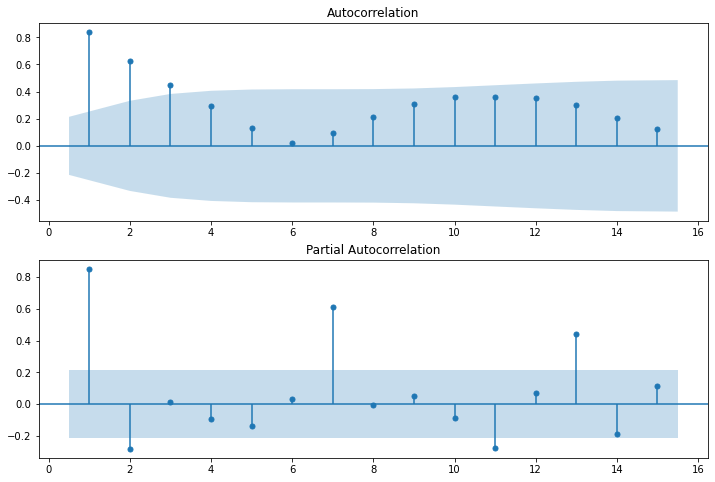

In [56]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of savings on ax1
plot_acf(ts_train,zero=False,lags=15,ax=ax1)
# Plot the PACF of savings on ax2
plot_pacf(ts_train,zero=False,lags=15,ax=ax2)
plt.show()

The ACF shows a steady decay with 3 lags showing as significant. The PACF also shows 3 statistically large spikes. In combination, these findings suggest an ARMA model.

To be sure, we can fit different ARMA models and find the one that best fits the data. 

In [40]:
def fit_ts_model(ts,p0=1,r0=1,q0=1):
    #find best parameters for seasonal ARMIA model
    params_df = pd.DataFrame(columns=['p','r','q','AIC','BIC'])

    # Loop over p values
    for p in range(0,p0):

        # Loop over p values
        for r in range(0,r0):

          # Loop over q values
            for q in range(0,q0):
              try:
                # Create and fit ARMA(p,q) model
                model = sm.tsa.statespace.SARIMAX(ts, order=(p,r,q), trend='c')
                results = model.fit()

                # Print p, q, AIC, BIC
                params_df = params_df.append({'p':p,'r':r,'q':q,'AIC':results.aic,'BIC':results.bic},ignore_index=True)
                #print(p,q,results.aic,results.bic)

              except:
                continue
                
                
    return(params_df)
                #print(p, r, q, None, None)

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
params_df = fit_ts_model(dsts_train,p0=4,r0=1,q0=4)

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\bwitt\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bwitt\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\bwitt\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

In [53]:
params_df.sort_values('BIC')

,p,r,q,AIC,BIC
11,2.0,0.0,3.0,-402.387346,-385.371628
8,2.0,0.0,0.0,-393.975484,-384.252217
5,1.0,0.0,1.0,-393.637657,-383.914390
4,1.0,0.0,0.0,-390.563186,-383.270736
2,0.0,0.0,2.0,-392.234700,-382.511433
3,0.0,0.0,3.0,-392.920703,-380.766619
7,1.0,0.0,3.0,-395.299991,-380.715090
14,3.0,0.0,2.0,-397.036827,-380.021110
6,1.0,0.0,2.0,-392.002267,-379.848183
12,3.0,0.0,0.0,-391.975704,-379.821620


Out of all models tests, the ARMA(2,3) model is the winner in terms of both AIC and BIC. Interestingly, a simple AR(2) model also does very well. 

It is good to check the diagnostic statistics for our best model to ensure there are no potential issues. 

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\bwitt\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


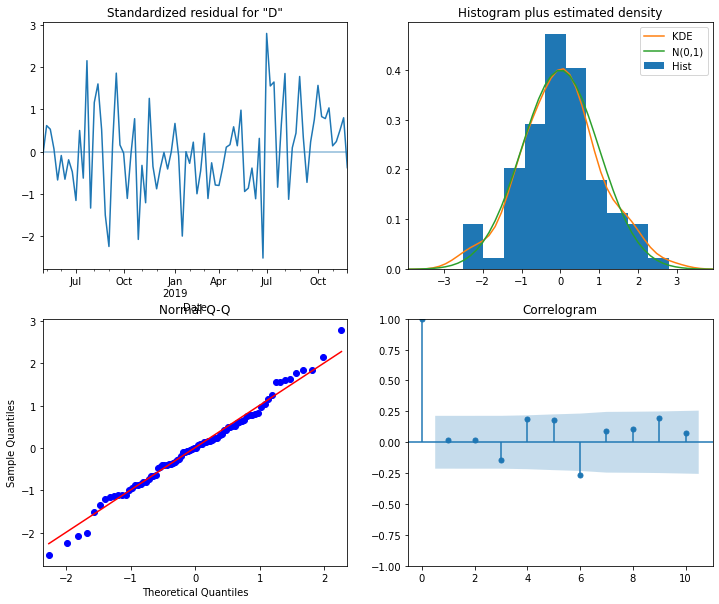

                               SARIMAX Results                                
Dep. Variable:               Delta_ts   No. Observations:                   84
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 208.194
Date:                Fri, 12 Nov 2021   AIC                           -402.387
Time:                        18:57:21   BIC                           -385.372
Sample:                    04-30-2018   HQIC                          -395.547
                         - 12-02-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0024      0.003     -0.723      0.470      -0.009       0.004
ar.L1          1.1876      0.117     10.141      0.000       0.958       1.417
ar.L2         -0.5355      0.119     -4.496      0.0

In [54]:
# Create and fit model
model = sm.tsa.statespace.SARIMAX(dsts_train,order=(2,0,3),trend='c')
results = model.fit()
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(12,10))
plt.show()
# Print summary
print(results.summary())

Fortunately, everything checks out for our model. The residuals are randomly and normally distributed and there is also no strong evidence for any autocorrelation.

## Time Series Predictions

The final part of this project will address the predictive power of our ARMA(1,0,3) time series. 

In [430]:
#split data into test and training sets
frac_train = 0.75
n_train = int(dsts.shape[0]*frac_train)
#training dataset
dsts_train = dsts_freq.iloc[0:n_train]
#testing dataset
dsts_test = dsts_freq.iloc[n_train:]

### Functions for time series forecasting

First, we use a naive prediction of the last value of the "train" time series and use that as the prediciton for the remainder of the time series. This baseline will allow us to quantify the effectivness of more sophisticated forecasting techniques.

We then define two forecasting functions. The first, ts_one_step_ahead does a repeated one-step ahead forecasting using the last forecasted value. The second function, ts_one_step_ahead_data, also makes one-step ahead predictions but uses the latest data point in the original time series as a starting point rather than the last predicted value. 

In [934]:
#naive forecast using the last value of the train ts
y_true = dsts_test.values
y_pred=[dsts_train[-1]]*len(y_true)

baseline_mse = np.round(mean_squared_error(y_true,y_pred),5)
baseline_mse

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.00082

In [797]:
#iterative one-step ahead using last forecasted value as starting point
def ts_one_step_ahead(df=dsts_train,periods=3):
    
    #initial time series for model 
    dfp = df.copy()
    
    #initalize predictions time series
    preds = dsts_test.copy()
    preds=preds.iloc[:periods]
    preds[:] = 0  

    for period in range(0,periods):
        # Create ARIMA model
        arima = SARIMAX(dfp,order=(1,0,3),trend='c')
        # Fit ARIMA model
        arima_results = arima.fit()
        
        #make one-step ahead prediction
        osap = arima_results.get_forecast(1)
        pred0 = osap.predicted_mean
        preds[period] = pred0.values
        
        #update time series with latest prediction
        dfp = dfp.append(pred0)
        
    return(preds)

In [680]:
#iterative one-step ahead using last time series data value as starting point
def ts_one_step_ahead_data(df=dsts_freq,periods=-30):
    
    #initalize predictions time series
    preds = df.iloc[periods:].copy()
    preds[:] = 0
    
    #iterate over all periods
    for period in range(periods,0):
        # Create ARIMA model
        arima = SARIMAX(df.iloc[:period],order=(1,0,3),trend='c')
        # Fit ARIMA model
        arima_results = arima.fit()
        
        #make one-step ahead prediction
        osap = arima_results.get_forecast(1)
        osap = osap.predicted_mean
        #print(osap)
        #update df with latest prediction
        #df = df.append(osap)
        preds[period] = osap
    
    return(preds)


C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\bwitt\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


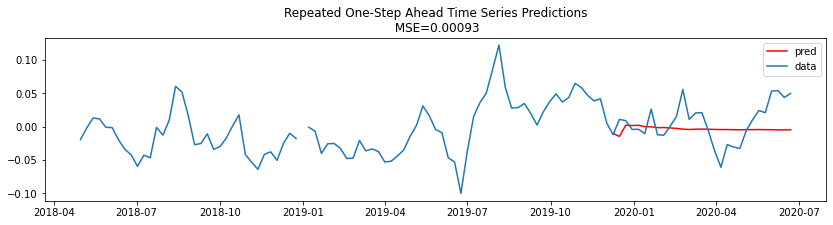

In [915]:
period_no = 29
#call one-step ahead function
tt = ts_one_step_ahead(periods=period_no)
#plot results
mse = mean_squared_error(y_true = dsts_freq.iloc[-period_no:],y_pred=tt.values)
plt.figure(figsize=(14,3))
plt.plot(tt,label='pred',color='red')
plt.plot(dsts_freq,label='data')
plt.legend()
plt.title('Repeated One-Step Ahead Time Series Predictions\n MSE={}'.format(mse.round(5)))
plt.show()

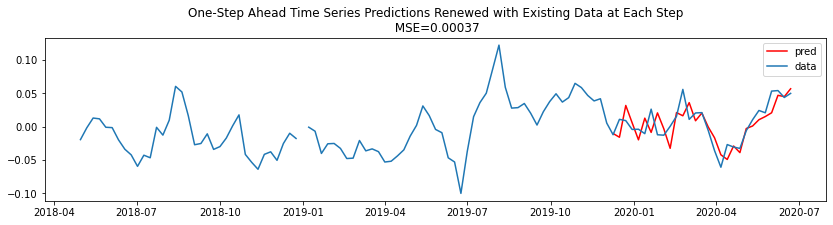

In [896]:
#call one-step ahead function
period_no = -29
tt = ts_one_step_ahead_data(periods=period_no)
#print(tt.values)
#print(dsts_freq.iloc[period_no:].values)
#plot results
mse = mean_squared_error(y_true = dsts_freq.iloc[period_no:],y_pred=tt.values)
plt.figure(figsize=(14,3))
plt.plot(tt,label='pred',color='red')
plt.plot(dsts_freq,label='data')
plt.legend()
plt.title('One-Step Ahead Time Series Predictions Renewed with Existing Data at Each Step\n MSE={}'.format(mse.round(5)))
plt.show()

The repeated one-step ahead forecast for the ARMA(1,0,3) model initially dips and then increases, but quickly plateaus due to the lack of additional shocks. In the case of the one-step ahead predictions where we use the latest data point in the time series rather than the last forecasted prediction, the fit is unsurprisingly much closer to the actual data (MSE = 0.0004 vs 0.0009).

A confidence interval can also be calculated from the standard deviation of the fitted model's residuals. A critical value of alpha = 0.05 can be acheieved using the predicted value +/- 1.96$\sigma$.

Below we write a function that uses the Python statsmodel package. Herein, the confidence intervals are still calculated manually even though the statsmodel package has built-in functions for this. 

In [57]:
#function to make and plot predictions of time series of deltas between sentiment score and market fluctuations
def ts_predictions(df=dsts_freq,test_df = dsts_test,forecast=True,periods = 1):
    
    # Create ARIMA model
    arima = SARIMAX(df,order=(2,0,3),trend='c')
    # Fit ARIMA model
    arima_results = arima.fit()
    
    #CI for alpha = 0.05. Uses 1.96*std of fitted model's residuals for calculation
    ci = 1.96*np.std(arima_results.resid)
    
    #set indexes for predictions
    start_index = df.shape[0]
    #do not let end_index exceed data in full time series
    end_index = start_index + periods#,dsts.shape[0])
    
    #type of predictions
    if forecast == False:
        preds=arima_results.get_prediction(start=-periods)
        preds_mean = preds.predicted_mean
    else:
        preds=arima_results.predict(start=start_index,end=end_index)
        #get index of predictions    
        pindx=preds.index
    
    #MSE
    if forecast==True:
        y_forecasted = preds
        y_truth = dsts_freq.loc[pindx]
    else:
        y_forecasted = preds_mean
        y_truth = dsts_test

    # Compute the mean square error
    mse = np.round(((y_forecasted - y_truth) ** 2).mean(),6)
    #print('The Mean Squared Error of the forecasts is {}'.format(round(mse, 5)))

    # Get confidence intervals of  predictions
    #
    #print(confidence_intervals)
    if forecast==True:
        lower_limits = preds - ci#confidence_intervals.loc[:,'lower Delta_ts']
        upper_limits = preds + ci#confidence_intervals.loc[:,'upper Delta_ts']
    else:
        confidence_intervals = preds.conf_int()
        lower_limits = confidence_intervals.loc[:,'lower Delta_ts']
        upper_limits = confidence_intervals.loc[:,'upper Delta_ts']        

    # plot the time series data
    plt.figure(figsize=(14,3)) 
    #plot the test data that is being predicted
    if forecast==True:
        plt.plot(df.index, df, label='observed')
        plt.plot(test_df.index,test_df,label='out of model observations',color='gray')
        # plot your mean predictions
        plt.plot(y_forecasted.index, y_forecasted, color='r', label='forecast')
    else:
        plt.plot(dsts_train.index, dsts_train, label='observed')
        plt.plot(test_df.index,test_df,color='grey',label='observations')
        # plot your mean predictions
        plt.plot(preds_mean.index,preds_mean, color='r', label='forecast')        
    # shade the area between your confidence limits
    plt.fill_between(lower_limits.index, lower_limits,
             upper_limits, color='pink')
    
    # set labels, legends and show plot
    if forecast == True:
        tdp = 'out of model observations'
    elif forecast == False:
        tdp = 'one-step ahead'
    
    #plot results    
    plt.xlabel('Date')
    plt.ylabel('Delta')
    plt.title('Time Series {} predictions\n MSE={}'.format(tdp,np.round(mse,5)))
    plt.legend()
    plt.show()
    
    #print(y_forecasted)

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\bwitt\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


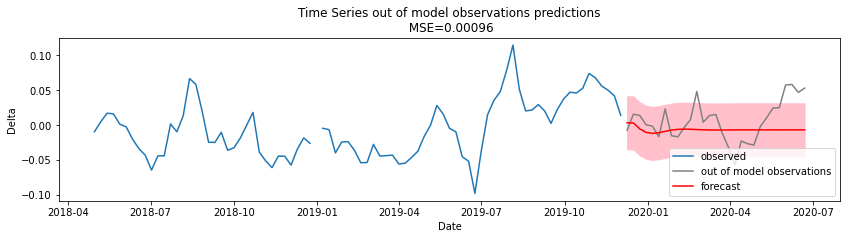

In [58]:
ts_predictions(df=dsts_train,periods=28)

C:\Users\bwitt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\bwitt\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


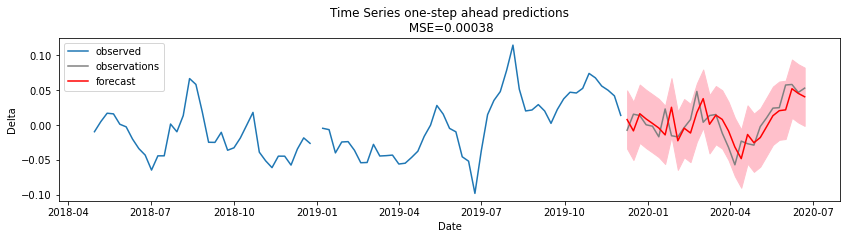

In [59]:
ts_predictions(df=dsts_freq,periods=29,forecast=False)

## Conclusions

We took articles from three separate news sources and calculated the sentiment scores of their headlines and article descriptions as well as the average of the two. The CNBC articles description sentiment scores had the best correlation with the S&P 500 price fluctuations. The best correlation was acheived with a differenced lag of 4 weeks relative to the stock market data, meaning that the article description sentiment best predicted stock market fluctations 4 weeks ahead. In addition, a moving average of 6 weeks improved the statistically significant (p~0.01) correlation to just above 0.41. 

Building upon our analysis, we fitted an array of time series to the S&P 500 and sentiment scores differenced data. A best fit  ARMA(1,0,3) model was found. Forecasting with both one-step ahead and multiple step time algorithms, we determined that the one-step ahead model had a MSE of 0.0003, which performed better than the naive prediction of simply using the last values of the 'training' time series data of MSE=0.0008. However, a 29-multistep forecast had slightly worse performance than the naive model with MSE=0.0009. 